In [1]:
#imports to work with...
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
from cl_framework.continual_learning.models.BaseModel import BaseModel

from cl_framework.dataset.dataset_utils import get_dataset
from tqdm import tqdm

In [2]:
# this is used later to create the class_to_idx
def kinetics_classes(classes_csv):
    df = pd.read_csv(classes_csv)
    classes_behaviors = {}

    for _, row in df.iterrows():
        class_name = row['Category']
        subcategory = row['Subcategory']
        
        # Check if the class_name is already in the dictionary, if not, create a new entry
        if class_name not in classes_behaviors:
            classes_behaviors[class_name] = []
        
        # Add the subcategory to the corresponding class_name entry in the dictionary
        classes_behaviors[class_name].append(subcategory)

    return classes_behaviors

In [3]:
#create a mapping between classes - behaviors
folder_csv = '../Kinetics/Info/'
class_csv = os.path.join(folder_csv, 'classes.csv')
classes_behaviors = kinetics_classes(class_csv)

#create a index for each class -- {class: idx}
class_to_idx = {key: i for i, key in enumerate(classes_behaviors.keys())}


In [4]:
predictions_names = ['food', 'phone','smoking','fatigue','selfcare']

all_behaviors_dict = {
    'food': [
        'eating burger', 'eating cake', 'eating carrots', 'eating chips', 'eating doughnuts',
        'eating hotdog', 'eating ice cream', 'eating spaghetti', 'eating watermelon',
        'sucking lolly', 'tasting beer', 'tasting food', 'tasting wine', 'sipping cup'
    ],
    'phone': [
        'texting', 'talking on cell phone', 'looking at phone'
    ],
    'smoking': [
        'smoking', 'smoking hookah', 'smoking pipe'
    ],
    'fatigue': [
        'sleeping', 'yawning', 'headbanging', 'headbutting', 'shaking head'
    ],
    'selfcare': [
        'scrubbing face', 'putting in contact lenses', 'putting on eyeliner', 'putting on foundation',
        'putting on lipstick', 'putting on mascara', 'brushing hair', 'brushing teeth', 'braiding hair',
        'combing hair', 'dyeing eyebrows', 'dyeing hair'
    ]
    }


n_task = 6
total_classes = 5

In [45]:
#load dataset and create dataloader
pretrained_path = 'not_none'
data_path = '../Kinetics'
dataset = 'kinetics'
test_set, _, _, total_classes, subcat_dict = get_dataset(dataset, data_path, pretrained_path)
test_loaders = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=4)
device = "cuda:" + str(0)

Loading Kinetics


In [46]:
#Instantiate a model
backbone = 'movinetA0'
model = BaseModel(backbone=backbone, dataset=dataset)
model.add_classification_head(total_classes)

#Load checkpoint and model
out_path = '../runs_trainings/from_checkpoint_sgd/lwf/incremental_decremental/seed_0/incdec_lwf_J8ASoD3F/best_mAP_task_1_model.pth'
model.load_state_dict(torch.load(out_path, map_location=device))
print("Model Loaded {}".format(out_path))

Model Loaded ../runs_trainings/from_checkpoint_sgd/lwf/incremental_decremental/seed_0/incdec_lwf_J8ASoD3F/best_mAP_task_1_model.pth


In [53]:
subcategories  = [
        'sleeping', 'yawning', 'headbanging', 'headbutting', 'shaking head'
]

class_idx_feat = {v:i for i, v in enumerate(subcategories)}

feature_list = [] 
subcat_list = []
target_list = [] 
model.eval()
model.to(device)
for batch_idx, (images, targets, _, subcat, _) in enumerate(tqdm(test_loaders)):
    if targets == class_to_idx['fatigue']:
        with torch.no_grad():
            images = images.to(device)
            _, features = model(images)
            
            features = features.view(1, 2048) 

            feature_list.append(features.detach().cpu())
            subcat_list.append(subcat[0])
            target_list.append(class_idx_feat[subcat[0]])
            

100%|██████████| 3700/3700 [01:25<00:00, 43.15it/s]


In [54]:
feature_list = torch.cat(feature_list, dim=0)
target_list = torch.tensor(target_list)

In [55]:
feature_list.shape

torch.Size([500, 2048])

In [56]:
#make t-SNE
features = np.array(feature_list)
from sklearn.preprocessing import StandardScaler
features = StandardScaler().fit_transform(features)

tsne = TSNE(n_components=2, perplexity=50, random_state=0)
feat_tsne = tsne.fit_transform(features)

/home/caselli/miniconda3/envs/data_incdec/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/caselli/miniconda3/envs/data_incdec/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [57]:
feat_tsne.shape

(500, 2)

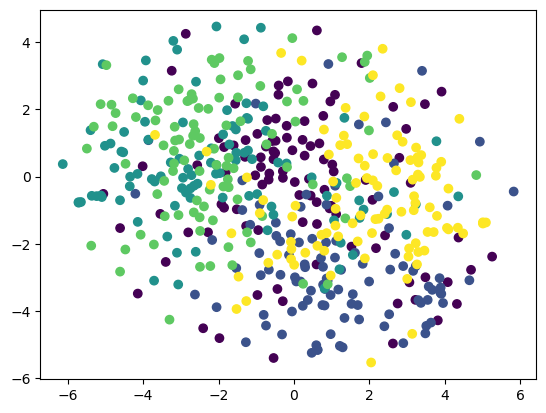

In [58]:
import matplotlib.pyplot as plt 

 
subcat_list = np.array(subcat_list)
plt.scatter(x=feat_tsne[:, 0], y=feat_tsne[:, 1], c=target_list)
plt.show()
# fig.update_layout(
#     title="t-SNE visualization of Customer Churn dataset",
#     xaxis_title="First t-SNE",
#     yaxis_title="Second t-SNE",
# )
 